In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, List

from egttools.games import AbstractNPlayerGame
from egttools import sample_simplex, calculate_nb_states
from egttools.analytical import PairwiseComparison
from egttools.utils import calculate_stationary_distribution
from egttools.plotting import draw_invasion_diagram

/home/plouis/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [39]:
class PGGWithLongCommitment(AbstractNPlayerGame):
    def __init__(self, 
                 group_size: int,   # Number of participants in the PGG
                 c: float,          # Cost of cooperation
                 r: float,          # Enhancing factor (multiplier)
                 eps: float,        # Cost to propose a commitment
                 delta: float,      # Cost for not respecting the commitment
                 gamma: float,      # Cost for punishing
                 F: int
                 ):
        # Initialize superclass
        AbstractNPlayerGame.__init__(self, 6, group_size)  # Adjusted for additional strategies

        # Parameters and configurations
        self.nb_strategies_ = 6
        self.group_size_ = group_size
        self.strategies = [
            "COMPF","C","P", "D", "FAKE", "FREE",
        ]

        self.c = c
        self.r = r
        self.eps = eps
        self.delta = delta
        self.gamma = gamma
        self.F = F 
        self.nb_group_configurations_ = self.nb_group_configurations()  # Calculate number of possible group configurations
        self.calculate_payoffs()  # Calculate payoffs for each strategy in different group configurations
    def get_strategy(self,
                        group_composition: Union[List[int], np.ndarray],
                        strategy: str,
                        ):
            
            propose_commit = False # D (but also FAKE)
            accept_commit = False # D
            contribute = False # D (but also FAKE)
            punish = False # P
            
            if "COMP" in strategy:
                propose_commit = True
                accept_commit = True
                contribute=True
            elif strategy=="C":
                accept_commit = True
                contribute=True
            elif strategy=="P":
                propose_commit = False
                accept_commit = True
                contribute=True
                punish = True
            elif strategy=="FREE":
                accept_commit = True
                if group_composition[0]>0:
                    contribute=True
            elif strategy=="FAKE":
                accept_commit = True

            return propose_commit, accept_commit, contribute, punish
    

        
    def play(self, group_composition: Union[List[int], np.ndarray], game_payoffs: np.ndarray) -> None:
        # Initialize payoffs for each strategy in the group
        game_payoffs[:] = 0.
        # Calculate the number of each type of player in the group
        nb_commitment = group_composition[0]

        if nb_commitment == 0:  # Classical PGG
            nb_contributors = group_composition[1]
        else:  # With commitments
            nb_contributors = nb_commitment + group_composition[1] + group_composition[4] + group_composition[5]

        nb_fake = group_composition[3]  # Number of fake players
        nb_accept = nb_fake + nb_contributors

        # Calculate the total contribution and reward for the group
        total_contribution = self.c * nb_contributors
        total_reward = self.r * total_contribution
        individual_reward = total_reward / self.group_size_

        if nb_commitment==0 or self.F<=nb_accept:
           for index, strategy_count in enumerate(group_composition):
            if strategy_count > 0:
                propose_commit, accept_commit, contribute,punish = self.get_strategy(group_composition, self.strategies[index]) 
                game_payoffs[index] += individual_reward
                if contribute:
                    game_payoffs[index] -=  self.c
                if propose_commit:
                     game_payoffs[index] -=  ((self.eps) - (nb_fake*self.delta))/nb_commitment
                if accept_commit and not contribute:
                    game_payoffs[index] -= self.delta
                if punish:
                    game_payoffs[index] -= self.gamma
                if not contribute : 
                    game_payoffs[index] -= self.gamma

                
    def calculate_payoffs(self) -> np.ndarray:
        """Calculate and store the payoffs for each strategy in the game."""

        # Initialize an array to store payoffs for each configuration
        payoffs_container = np.zeros(shape=(self.nb_strategies_,), dtype=np.float64)

        # Loop over all possible group configurations
        for i in range(self.nb_group_configurations_):
            # Generate a sample group composition
            group_composition = sample_simplex(i, self.group_size_, self.nb_strategies_)
            group_composition = np.array(group_composition, dtype=float)

            # Play the game with the given group composition
            self.play(group_composition, payoffs_container)

            # Update the payoff for each strategy based on this configuration
            for strategy_index, strategy_payoff in enumerate(payoffs_container):
                self.update_payoff(strategy_index, i, strategy_payoff)

            # Reset the payoff container for the next configuration
            payoffs_container[:] = 0

        return self.payoffs()


In [40]:
class PGGWithCommitment(AbstractNPlayerGame):
    def __init__(self, 
                 group_size: int,   # Number of participants in the PGG
                 c: float,          # Cost of cooperation
                 r: float,          # Enhancing factor (multiplier)
                 eps: float,        # Cost to propose a commitment
                 delta: float,      # Cost for not respecting the commitment
                 gamma: float,      # Cost for punishing
                 F: int
                 ):
        # Initialize superclass
        AbstractNPlayerGame.__init__(self, 3, group_size)  # Adjusted for additional strategies

        # Parameters and configurations
        self.nb_strategies_ = 3
        self.group_size_ = group_size
        self.strategies = [
            "COMPF","C", "D"
        ]

        self.c = c
        self.r = r
        self.eps = eps
        self.delta = delta
        self.gamma = gamma
        self.F = F 
        self.nb_group_configurations_ = self.nb_group_configurations()  # Calculate number of possible group configurations
        self.calculate_payoffs()  # Calculate payoffs for each strategy in different group configurations
    def get_strategy(self,
                        group_composition: Union[List[int], np.ndarray],
                        strategy: str,
                        ):
            
            propose_commit = False # D (but also FAKE)
            accept_commit = False # D
            contribute = False # D (but also FAKE)
            punish = False # P
            
            if "COMP" in strategy:
                propose_commit = True
                accept_commit = True
                contribute=True
            elif strategy=="C":
                accept_commit = True
                contribute=True

            return propose_commit, accept_commit, contribute, punish
    

        
    def play(self, group_composition: Union[List[int], np.ndarray], game_payoffs: np.ndarray) -> None:
        # Initialize payoffs for each strategy in the group
        game_payoffs[:] = 0.
        # Calculate the number of each type of player in the group
        nb_commitment = group_composition[0]

        if nb_commitment == 0:  # Classical PGG
            nb_contributors = group_composition[1]
        else:  # With commitments
            nb_contributors = nb_commitment + group_composition[1]

        nb_accept = nb_contributors

        # Calculate the total contribution and reward for the group
        total_contribution = self.c * nb_contributors
        total_reward = self.r * total_contribution
        individual_reward = total_reward / self.group_size_

        if nb_commitment==0 or self.F<=nb_accept:
           for index, strategy_count in enumerate(group_composition):
            if strategy_count > 0:
                propose_commit, accept_commit, contribute,punish = self.get_strategy(group_composition, self.strategies[index]) 
                game_payoffs[index] += individual_reward
                if contribute:
                    game_payoffs[index] -=  self.c
                if propose_commit:
                     game_payoffs[index] -=  ((self.eps))/nb_commitment
                if accept_commit and not contribute:
                    game_payoffs[index] -= self.delta

                
    def calculate_payoffs(self) -> np.ndarray:
        """Calculate and store the payoffs for each strategy in the game."""

        # Initialize an array to store payoffs for each configuration
        payoffs_container = np.zeros(shape=(self.nb_strategies_,), dtype=np.float64)

        # Loop over all possible group configurations
        for i in range(self.nb_group_configurations_):
            # Generate a sample group composition
            group_composition = sample_simplex(i, self.group_size_, self.nb_strategies_)
            group_composition = np.array(group_composition, dtype=float)

            # Play the game with the given group composition
            self.play(group_composition, payoffs_container)

            # Update the payoff for each strategy based on this configuration
            for strategy_index, strategy_payoff in enumerate(payoffs_container):
                self.update_payoff(strategy_index, i, strategy_payoff)

            # Reset the payoff container for the next configuration
            payoffs_container[:] = 0

        return self.payoffs()


In [31]:
# There is no non participants in this game
class PGGwithCP(AbstractNPlayerGame):
    def __init__(self, 
                 group_size: int,  # number of participants in the PGG
                 c: float,  # cost of cooperation
                 r: float,  # enhancing factor for the public goods
                 gamma: float,  # cost for punishers to impose fines
                 beta: float,  # fine imposed by each punisher on each defector
                ):
        super().__init__(3, group_size)
        self.nb_strategies_ = 3
        self.group_size_ = group_size


        self.strategies = ["C", "D", "P"]
        self.c = c
        self.r = r
        self.g = gamma
        self.b = beta
        
        self.nb_group_configurations_ = self.nb_group_configurations()
        self.calculate_payoffs()

    def get_strategy(self, strategy: str):
        """Define actions based on each strategy."""
        
        contribute = False
        punish = False
        
        if strategy == "C":  # Cooperators
            contribute = True
        elif strategy == "D":  # Defectors
            pass
        elif strategy == "P":  # Punishers
            contribute = True
            punish = True
        
        return contribute, punish
                
    def play(self, group_composition: Union[List[int], np.ndarray], game_payoffs: np.ndarray) -> None:
        COOPERATOR, DEFECTOR, PUNISHER = 0, 1, 2

        if  self.group_size_ > 1: # Condition in the paper S > 1 but here all participants are compulsory
            nb_contributors = group_composition[COOPERATOR] + group_composition[PUNISHER]
            total_contribution = self.c * nb_contributors
            total_reward = self.r * total_contribution
            individual_reward = total_reward / self.group_size_ 
  
            for index, _ in enumerate(group_composition):
                    contributes, punishes = self.get_strategy(self.strategies[index])
                    
                    game_payoffs[index] += individual_reward # other participants get individual reward

                    if contributes:                               # actions by cooperators                                              
                        game_payoffs[index] -= self.c           # the cooperators and the punnishers is reduced by c

                    if punishes:                                # actions by punishers
                        game_payoffs[index] -= self.g * group_composition[DEFECTOR] # the defectors is reduced by gamma * Nw
                    
                    if self.strategies[index] == "D" and group_composition[PUNISHER] > 0:
                        game_payoffs[index] -= self.b * group_composition[PUNISHER] # the defectors is reduced by beta * Nw

        else:
            return # no game

    def calculate_payoffs(self) -> np.ndarray:
        """Calculate and store the payoffs for each strategy in the game."""
        
        payoffs_container = np.zeros(shape=(self.nb_strategies_,), dtype=np.float64)
        
        for i in range(self.nb_group_configurations_):
            # Generate a sample group composition
            group_composition = sample_simplex(i, self.group_size_, self.nb_strategies_)
            group_composition = np.array(group_composition, dtype=float)

            # Play the game with the given group composition
            self.play(group_composition, payoffs_container)

            # Store payoffs for each strategy
            for strategy_index, strategy_payoff in enumerate(payoffs_container):
                self.update_payoff(strategy_index, i, strategy_payoff)
                
            # Reset the payoff container for the next configuration
            payoffs_container[:] = 0

        return self.payoffs()

Printing with all strats

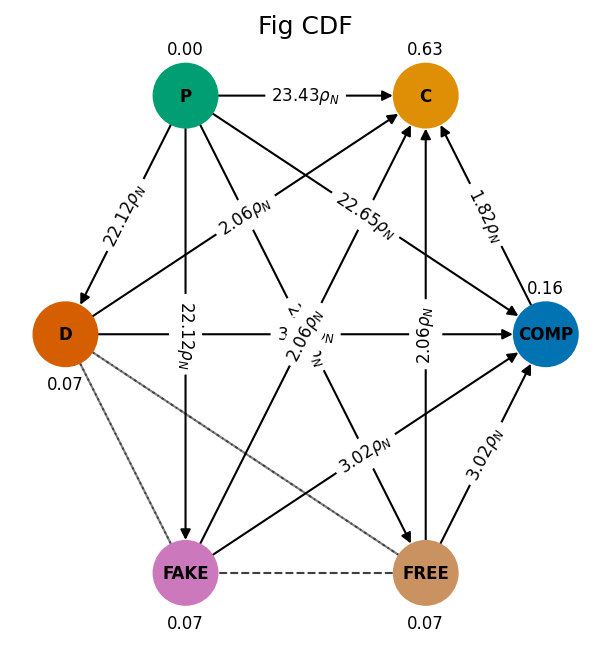

CDF 0.1587450368181203


In [43]:
# Parameters of the game:
strategy_labels = [
            "COMPF","C","P", "D", "FAKE", "FREE",
        ]
nb_strategies = len(strategy_labels)

group_size = 5
Z = 100
c = 1.0
beta = 0.25
gamma = 0.3
r = 4.
eps = 0.25
delta = 0
game = PGGWithLongCommitment(group_size, c, r, eps, delta, gamma, Z)
evolver = PairwiseComparison(Z, game)
transition_matrix,fixation_probabilities = evolver.calculate_transition_and_fixation_matrix_sml(beta)
stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)

G = draw_invasion_diagram(strategy_labels,
                       1/Z, 
                       fixation_probabilities,
                       stationary_distribution,
                       node_size=1000, 
                       font_size_node_labels=8,
                       font_size_edge_labels=8,
                       font_size_sd_labels=8,
                       edge_width=1,
                       min_strategy_frequency=-0.1, 
                       ax=ax)
plt.axis('off')
plt.title("Fig CDF" )
plt.show() # display
a =stationary_distribution[0] + stationary_distribution[2]
print("CDF",a)

Print focusing on COMPF

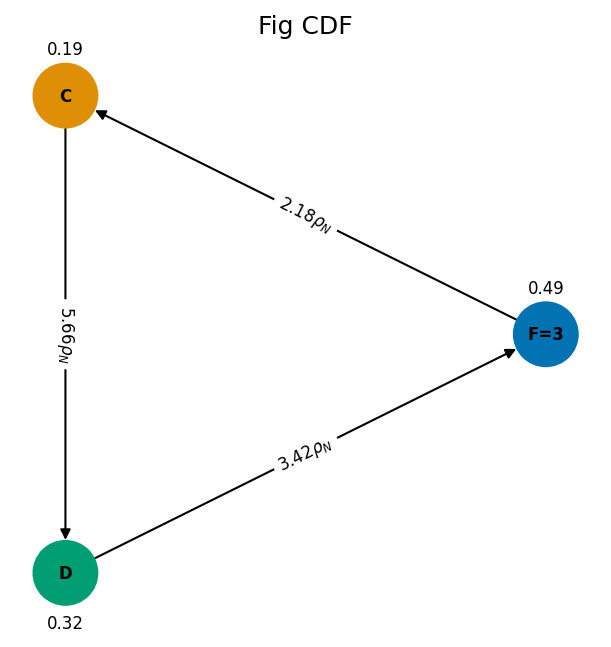

CDF 0.6759761074442237


In [ ]:
# Parameters of the game:
strategy_labels = ["F=3","C","D"]
nb_strategies = len(strategy_labels)

group_size = 5
Z = 100
c = 1.0
beta = 0.25
gamma = 3
r = 4.
eps = 0.25
delta = 0
game = PGGWithLongCommitment(group_size, c, r, eps, delta, gamma,3)
evolver = PairwiseComparison(Z, game)
transition_matrix,fixation_probabilities = evolver.calculate_transition_and_fixation_matrix_sml(beta)
stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)

G = draw_invasion_diagram(strategy_labels,
                       1/Z, 
                       fixation_probabilities,
                       stationary_distribution,
                       node_size=1000, 
                       font_size_node_labels=8,
                       font_size_edge_labels=8,
                       font_size_sd_labels=8,
                       edge_width=1,
                       min_strategy_frequency=-0.1, 
                       ax=ax)
plt.axis('off')
plt.title("Fig CDF" )
plt.show() # display
a =sum(stationary_distribution[:2])
print("CDCOMPF",a)

Print focusing on punishers

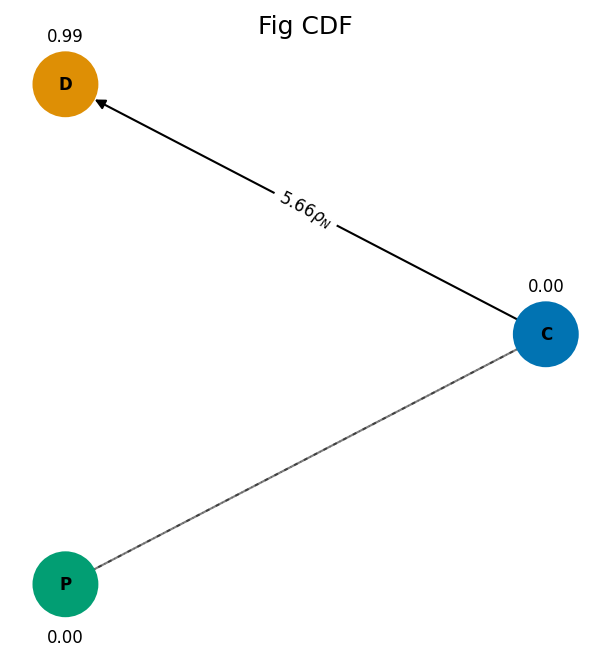

CDF 0.005946492357910192


In [ ]:
# Parameters of the game:
strategy_labels = ["C","D","P"]
nb_strategies = len(strategy_labels)

group_size = 5
Z = 100
c = 1.0
beta = 0.25
gamma = 0.3
r = 4.
eps = 0.25
delta = 0
game = PGGwithCP(group_size, c, r, gamma, beta)
evolver = PairwiseComparison(Z, game)
transition_matrix,fixation_probabilities = evolver.calculate_transition_and_fixation_matrix_sml(beta)
stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)

G = draw_invasion_diagram(strategy_labels,
                       1/Z, 
                       fixation_probabilities,
                       stationary_distribution,
                       node_size=1000, 
                       font_size_node_labels=8,
                       font_size_edge_labels=8,
                       font_size_sd_labels=8,
                       edge_width=1,
                       min_strategy_frequency=-0.1, 
                       ax=ax)
plt.axis('off')
plt.title("Fig CDP" )
plt.show() # display
a =stationary_distribution[0] + stationary_distribution[2]
print("CDF",a)